In [1]:
from pharynx_analysis import (pharynx_io as pio, image_processing as ip, experiment, plots, profile_processing)
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from importlib import reload
from skimage import measure, transform
from collections import namedtuple
import pdb
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import scale
import skimage
import logging
from mpl_toolkits.axes_grid1 import ImageGrid
import pandas as pd
import seaborn as sns
import tqdm
from scipy.spatial import distance
from numba import jit


reload(logging)
reload(experiment)
reload(pio)
reload(ip)
reload(plots)
reload(profile_processing)

logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%I:%M:%S')

In [2]:
experiment_dir = "/Users/sean/code/wormAnalysis/data/paired_ratio/2017_02_22-HD233_SAY47"
imaging_scheme = "TL/470/410/470/410"

reload(experiment);
ex = experiment.PairExperiment(
    experiment_dir=experiment_dir,
    imaging_scheme=imaging_scheme
)
ex.full_pipeline()

12:03:34 INFO:Starting full pipeline run for /Users/sean/code/wormAnalysis/data/paired_ratio/2017_02_22-HD233_SAY47
12:03:34 INFO:Loading Images
12:03:35 INFO:Segmenting pharynxes
12:03:36 INFO:Centering and rotating pharynxes
100%|██████████| 123/123 [00:08<00:00, 16.39it/s]
12:03:45 INFO:Calculating midlines
100%|██████████| 123/123 [00:01<00:00, 116.70it/s]
12:03:46 INFO:Measuring under midlines
100%|██████████| 123/123 [00:04<00:00, 27.96it/s]
12:03:53 INFO:Registering profiles
12:04:08 INFO:Trimming intensity data
12:04:10 INFO:Calculating redox measurements
12:04:11 INFO:Finished full pipeline run for /Users/sean/code/wormAnalysis/data/paired_ratio/2017_02_22-HD233_SAY47


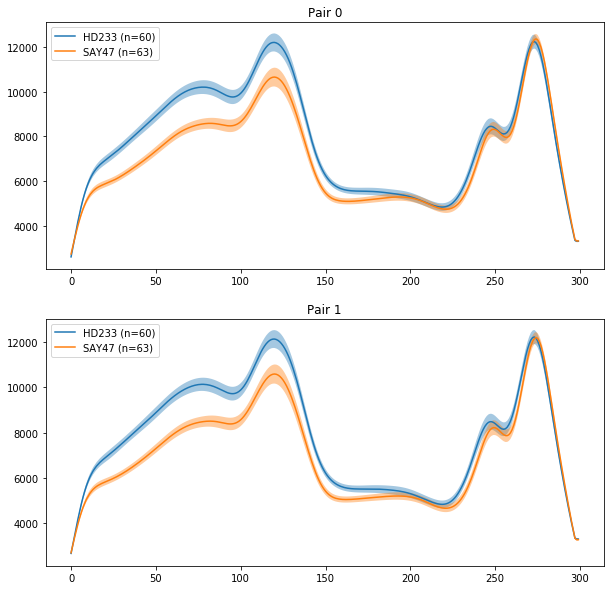

In [8]:
ax = plots.plot_average_by_strain_and_pair(ex.trimmed_raw_profiles.sel(wavelength='410'), legend=True)

(-275, -265)

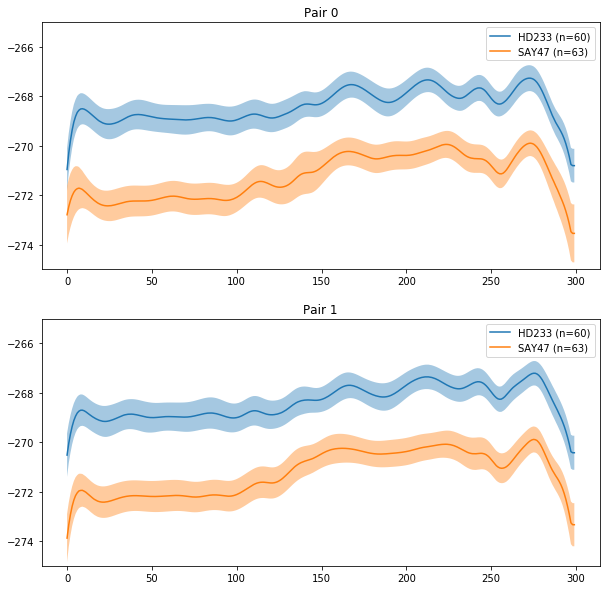

In [3]:
ax = plots.plot_average_by_strain_and_pair(ex.trimmed_raw_profiles.sel(wavelength='e'), legend=True)
ax[0].set_ylim([-275, -265])
ax[1].set_ylim([-275, -265])

(<Figure size 720x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x131202a58>)

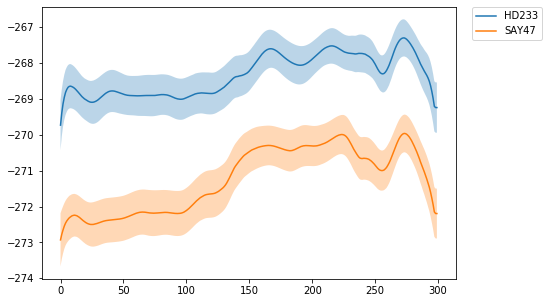

<Figure size 432x288 with 0 Axes>

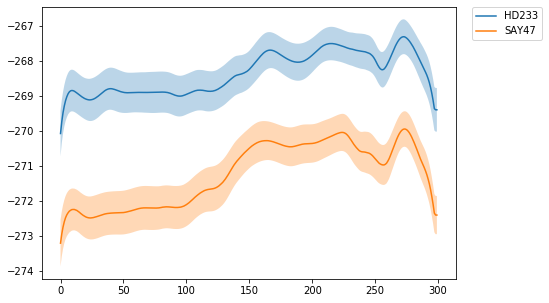

In [16]:
# ax = plots.plot_average_by_strain_and_pair(ex.trimmed_raw_profiles.sel(wavelength='r'), legend=True);
plots.plot_profile_avg_by_strain(ex.trimmed_reg_profiles.sel(wavelength='e', pair=0))
plt.figure()
plots.plot_profile_avg_by_strain(ex.trimmed_reg_profiles.mean(dim='pair').sel(wavelength='e'))

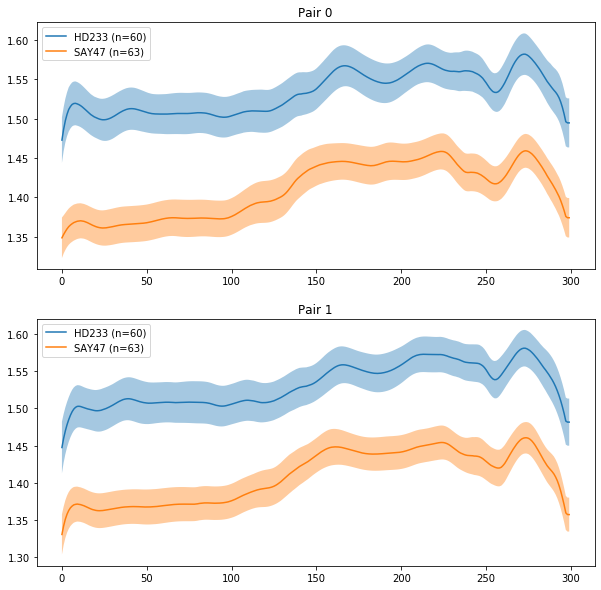

In [6]:
ax = plots.plot_average_by_strain_and_pair(ex.trimmed_reg_profiles.sel(wavelength='r'), legend=True);
# ax[0].set_ylim([-275, -265]);
# ax[1].set_ylim([-275, -265]);

In [1424]:
ex.reg_lambda = 10
ex.register()

01:32:32 INFO:Registering profiles


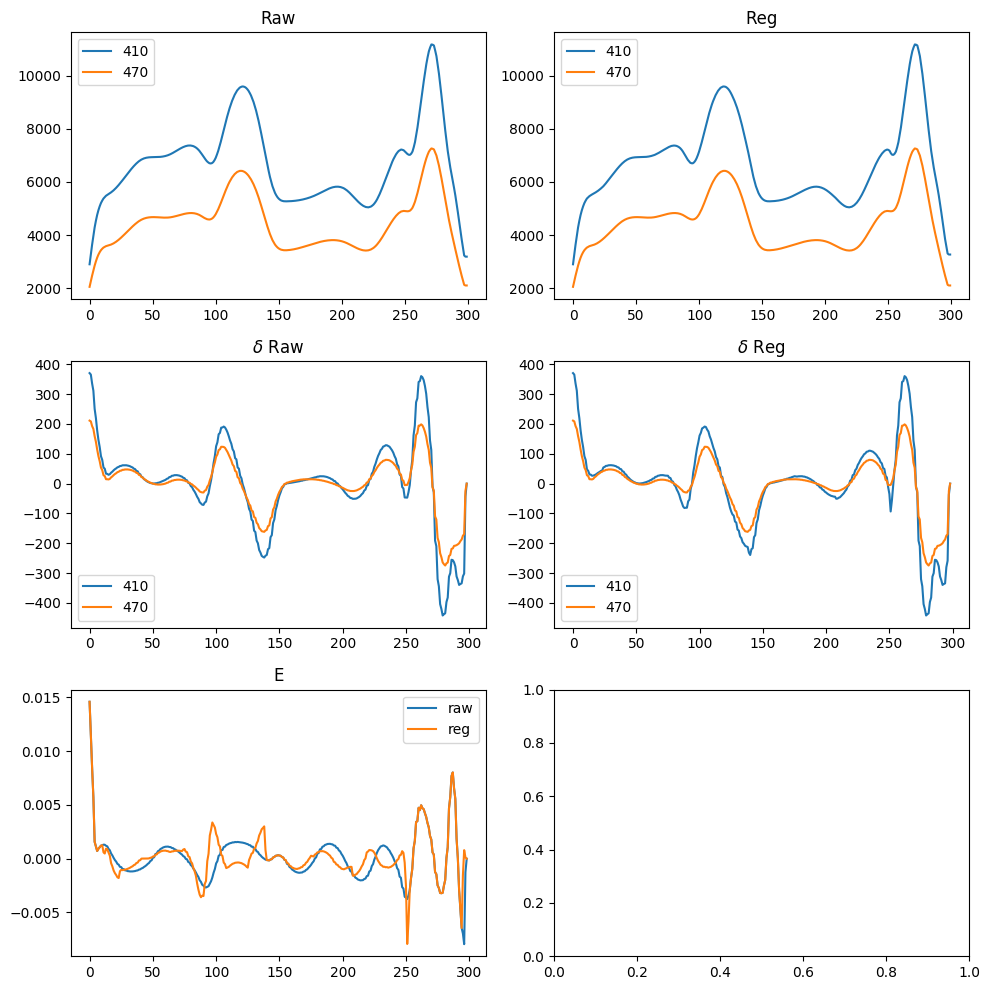

In [1425]:
# plt.imshow(ex.rot_fl[0].sel(wavelength='410', pair=0));
# mid = ex.midlines[0]['410'][0];
# mid_xs = np.linspace(mid.domain[0], mid.domain[1], 50);
# plt.plot(mid_xs, mid(mid_xs));
# plt.axvline(mid.domain[0]);
# plt.axvline(mid.domain[1]);

# plt.figure();
# plt.imshow(ex.rot_fl[0].sel(wavelength='470', pair=0));
# mid = ex.midlines[0]['470'][0];
# mid_xs = np.linspace(mid.domain[0], mid.domain[1], 50);
# plt.plot(mid_xs, mid(mid_xs));
# plt.axvline(mid.domain[0]);
# plt.axvline(mid.domain[1]);


i = i
fig, axes = plt.subplots(3, 2, figsize=(10, 10));

ax = axes[0,0]
ax.plot(ex.trimmed_raw_profiles[i].sel(wavelength='410', pair=0), label='410')
ax.plot(ex.trimmed_raw_profiles[i].sel(wavelength='470', pair=0), label='470')
ax.legend()
ax.set_title('Raw')

ax = axes[0,1]
ax.plot(ex.trimmed_reg_profiles[i].sel(wavelength='410', pair=0), label='410')
ax.plot(ex.trimmed_reg_profiles[i].sel(wavelength='470', pair=0), label='470')
ax.legend()
ax.set_title('Reg')

ax = axes[1,0]
ax.plot(np.diff(ex.trimmed_raw_profiles[i].sel(wavelength='410', pair=0)), label='410')
ax.plot(np.diff(ex.trimmed_raw_profiles[i].sel(wavelength='470', pair=0)), label='470')
ax.legend()
ax.set_title(r'$\delta$ Raw');

ax = axes[1,1]
ax.plot(np.diff(ex.trimmed_reg_profiles[i].sel(wavelength='410', pair=0)), label='410')
ax.plot(np.diff(ex.trimmed_reg_profiles[i].sel(wavelength='470', pair=0)), label='470')
ax.legend()
ax.set_title(r'$\delta$ Reg');

ax = axes[2,0]
ax.plot(np.diff(ex.trimmed_raw_profiles[i].sel(wavelength='oxd', pair=0)), label='raw')
ax.plot(np.diff(ex.trimmed_reg_profiles[i].sel(wavelength='oxd', pair=0)), label='reg')
ax.legend()
ax.set_title('E');

plt.tight_layout();

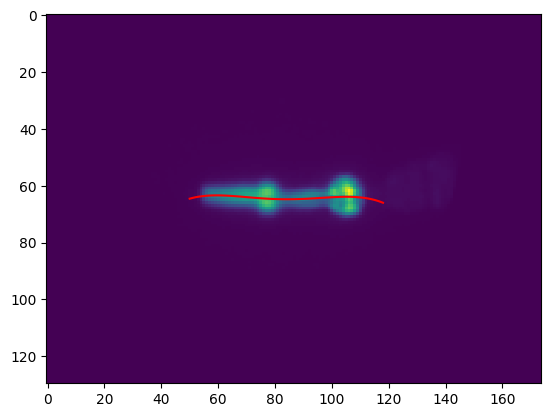

In [1408]:
i = i+1
I_fl = ex.rot_fl[i].sel(wavelength='410', pair=0)
mid = ex.midlines[i]['410'][0]
mid_xs = np.linspace(mid.domain[0], mid.domain[1], 100);
plt.imshow(I_fl)
plt.plot(mid_xs, mid(mid_xs), c='r');

# plt.axvline(left_bound)
# plt.axvline(right_bound)

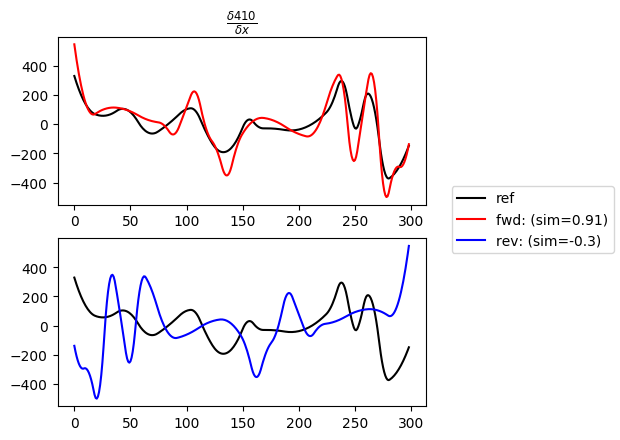

In [587]:
f_diff = sm.sel(wavelength='410', pair=0).diff('position')
r_diff = np.flip(f_diff, axis=1)

forwards = 1 - distance.cdist(f_diff, f_diff, 'cosine')[0,:]
reverses = 1 - distance.cdist(f_diff, r_diff, 'cosine')[0,:]

i=i+1
fig, axes = plt.subplots(2, 1)

l0 = axes[0].plot(f_diff[0], label='ref', color='k')[0]
_  = axes[1].plot(f_diff[0], color='k')
l1 = axes[0].plot(f_diff[i], c='r')[0]
l2 = axes[1].plot(r_diff[i], c='b')[0]

axes[0].set_title(r'$\frac{\delta 410}{\delta x}$');

fig.legend(handles=[l0, l1, l2],
           labels=['ref', f'fwd: (sim={forwards[i]:.2})', f'rev: (sim={reverses[i]:.2})'],
           loc=7)
fig.subplots_adjust(right=0.7)
# plt.tight_layout(rect=[0,0,0.75,1])
plt.savefig('/Users/sean/Desktop/align_pa.pdf')

In [1]:
xs = np.arange(200)
i = i + 1
n = 10
data = ex.raw_profiles.sel(wavelength='410', pair=0).isel(strain=i)



# for sm in np.linspace(0.0001, 100, 10):
sm  = 1e4
plt.plot(xs, UnivariateSpline(xs, data, s=sm)(xs), label=f'B-spline w/ smoothing lambda s={sm:.2}', c='r')
p = np.poly1d(np.polyfit(xs, data, n))
# plt.plot(p(xs), label=f'{n}th degree poly')
plt.scatter(xs, data, s=2, label='data', zorder=10, alpha=.3)
# plt.legend()

NameError: name 'np' is not defined

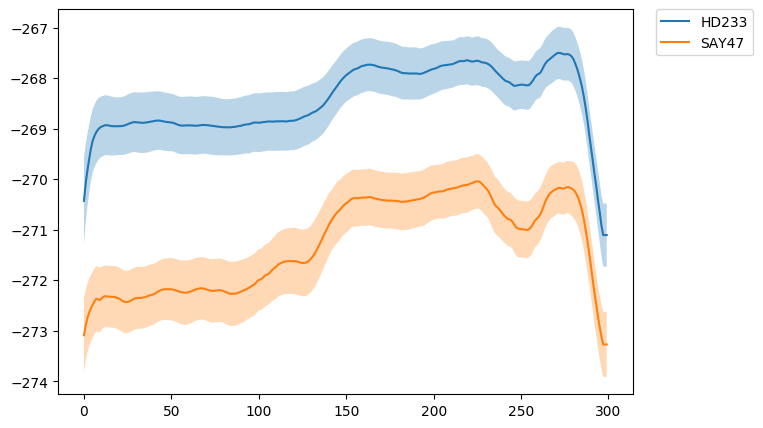

In [165]:
plots.plot_profile_avg_by_strain(
    d
);

87


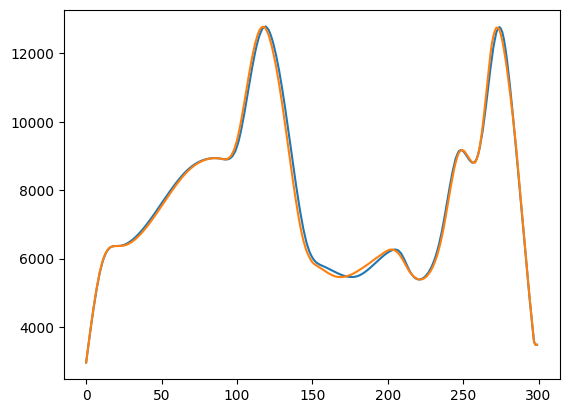

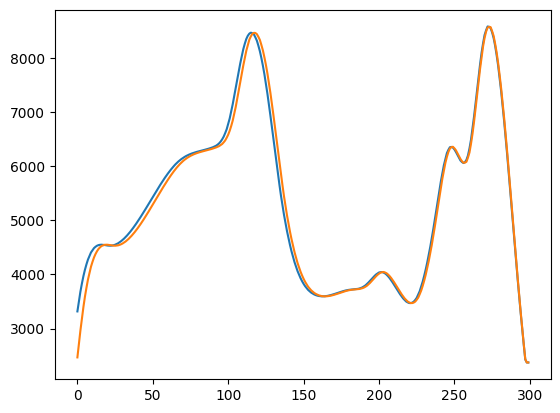

In [1409]:
# i = 17
# i = 18
i = i + 1
print(i)
plt.figure()
plt.plot(ex.trimmed_raw_profiles.sel(wavelength='410', pair=0).isel(strain=i))
plt.plot(ex.trimmed_reg_profiles.sel(wavelength='410', pair=0).isel(strain=i))

plt.figure()
plt.plot(ex.trimmed_raw_profiles.sel(wavelength='470', pair=0).isel(strain=i))
plt.plot(ex.trimmed_reg_profiles.sel(wavelength='470', pair=0).isel(strain=i))



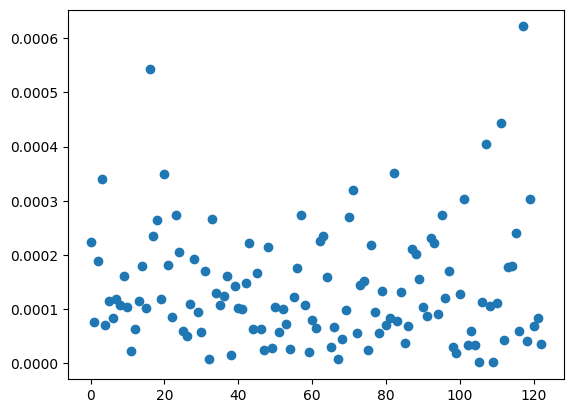

In [1434]:
i = 17
# i = 18
# i = i + 1
i410_raw = ex.trimmed_raw_profiles.sel(wavelength='410', pair=0)
i410_reg = ex.trimmed_reg_profiles.sel(wavelength='410', pair=0)

i470_raw = ex.trimmed_raw_profiles.sel(wavelength='470', pair=0)
i470_reg = ex.trimmed_reg_profiles.sel(wavelength='470', pair=0)

dists = distance.cdist(i410_raw, i410_reg, metric='cosine').diagonal()
plt.plot(dists, linestyle='', marker='o')

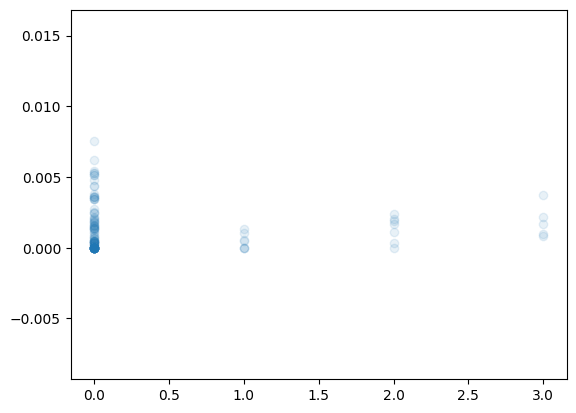

In [1432]:
mvmt = ex.movement.reset_index()

dists = distance.cdist(i470_raw, i470_reg, metric='cosine').diagonal()
plt.scatter(mvmt[mvmt.pair==0]['posterior'], dists, alpha=0.1)

In [1427]:
mvmt['total'] = mvmt['anterior'] + mvmt['posterior'] + mvmt['sides_of_tip']

(-0.002, 0.01)

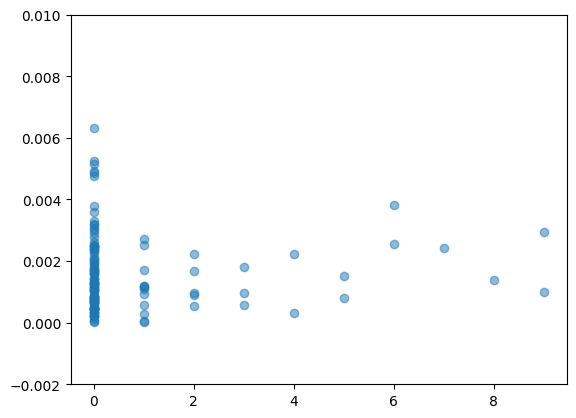

In [1429]:
scatter(mvmt[mvmt.pair==0]['total'], dists, alpha=0.5)
plt.ylim(-.002,.01)

In [1439]:
from fdasrsf import time_warping

ex.raw_profiles.sel(wavelength='410', pair=0).values.shape

ModuleNotFoundError: No module named 'optimum_reparamN'